#### Fetching the data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sidd1996","key":"411008e9f7f47955a0869b805c7a7240"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c m5-forecasting-accuracy

 63% 9.00M/14.2M [00:00<00:00, 14.1MB/s]
100% 14.2M/14.2M [00:00<00:00, 17.2MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 34.9MB/s]
 32% 5.00M/15.5M [00:00<00:01, 6.97MB/s]
100% 15.5M/15.5M [00:00<00:00, 20.0MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 73.9MB/s]
 32% 5.00M/15.8M [00:00<00:01, 7.12MB/s]
100% 15.8M/15.8M [00:00<00:00, 20.3MB/s]


In [ ]:
!unzip -q /content/sales_train_validation.csv.zip 
!unzip -q /content/sell_prices.csv.zip 
!unzip -q /content/sales_train_evaluation.csv.zip


In [ ]:
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install partd

     |████████████████████████████████| 92kB 5.7MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=dce891d93f42dd2477225d0ff0c1b6346160a13f553ac3c4567d354e22334121
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [ ]:
import os
# import gc
import time
import math
import datetime
from math import log, floor
# from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import Image

# import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet


import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
sales = pd.read_csv('/content/sales_train_evaluation.csv')
calendar = pd.read_csv('/content/calendar.csv')
sell_prices = pd.read_csv('/content/sell_prices.csv')


## Business Problem :-
M5 Forecasting Accuracy is a competetion in which we have to forecast future sales of each product in each store based on the hierarchical sales data provided by Walmart. In this competetion we have to forecast daily sales for next 28 days. Here we have the data for 3 states in US(California, Texas, and Wisconsin).
The data files (.csv files) provided for the competetion consists of item level, department, product categories,items sold on a day, store details, price, promotions, day of the week, and special events.
So by using this data we will forecast daily sales for next 28 days as accurately as possible.


## ML formulation :-
We will do some data preprocessing and feature engineering to get desired format and some new features respectively . Once the data is ready we will pass it through different machine learning and deep learning models . After the model is trained we will predict the values for test dataset.
We will pose this as a supervised machine learning regression problem. In this problem we will be using LGBMRegressor, Facebook Prophet and a deep learning model.

## Metrics :-

The performance measures are first computed for each series separately by averaging their values across the forecasting horizon and then averaged again across the series in a weighted fashion .

Forcasting horizon or number of days for which forecast is required is 28 days.

The metric used for evaluating the accuracy of the each series is Root Mean Squared Scaled Error (RMSSE).  


After estimating the RMSSE for all the 42,840 time series of the competition, we will calculate Weighted RMSSE (WRMSSE) which will be used as our final metric .

The formulas for RMSSE and WRMSSE are given below :-


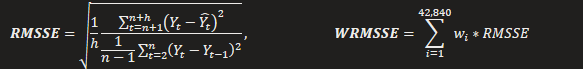


RMSSE variables :- Y_t is the actual future value of the examined time series at point t, (Y_t^)the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. 

WRMSSE variables :- w_i is the weight of the i_th series of the competition. A lower WRMSSE score is better.Explaination on how to calculate w_i is given in the pdf present in M5 Participants Guide :- https://mofc.unic.ac.cy/m5-competition/ .



## Downcasting

In [ ]:
### Ref link :- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling/comments#1.-Fetch-the-data


#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  


In [ ]:
sales = downcast(sales)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

##EDA

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [ ]:
sales = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id','state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0


In [ ]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [ ]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
df = pd.merge(sales, calendar,how = "left",on = 'd')

In [ ]:
df = pd.merge(df, sell_prices, how = 'left', on = ['store_id','item_id','wm_yr_wk'])

## Plot 1 :- Total number of products sold over time per store.


In [ ]:

df_1 = df.loc[df['store_id'] == 'CA_1']
grouped = df_1.groupby(['date']).sum()

In [ ]:
grouped = df.groupby(['store_id','date']).sum()
grouped.reset_index( inplace=True)

In [ ]:
grouped

,store_id,date,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
0,CA_1,2011-01-29,4337.0,33846949.0,3049.0,3049.0,6131539.0,0.0,0.0,0.0,4912.0
1,CA_1,2011-01-30,4155.0,33846949.0,6098.0,3049.0,6131539.0,0.0,0.0,0.0,4912.0
2,CA_1,2011-01-31,2816.0,33846949.0,9147.0,3049.0,6131539.0,0.0,0.0,0.0,4912.0
3,CA_1,2011-02-01,3051.0,33846949.0,12196.0,6098.0,6131539.0,3049.0,3049.0,0.0,4912.0
4,CA_1,2011-02-02,2630.0,33846949.0,15245.0,6098.0,6131539.0,3049.0,0.0,3049.0,4912.0
...,...,...,...,...,...,...,...,...,...,...,...
19405,WI_3,2016-05-18,3268.0,35417184.0,15245.0,15245.0,6146784.0,0.0,0.0,0.0,13704.0
19406,WI_3,2016-05-19,3398.0,35417184.0,18294.0,15245.0,6146784.0,0.0,0.0,0.0,13704.0
19407,WI_3,2016-05-20,4126.0,35417184.0,21343.0,15245.0,6146784.0,0.0,0.0,0.0,13704.0
19408,WI_3,2016-05-21,4519.0,35420233.0,3049.0,15245.0,6146784.0,0.0,0.0,0.0,13688.0


In [1]:
# import plotly.express as px
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'store_id' ,title='Total number of products sold over time per store')
fig.update_layout(width=1000, height=400)
fig.show()

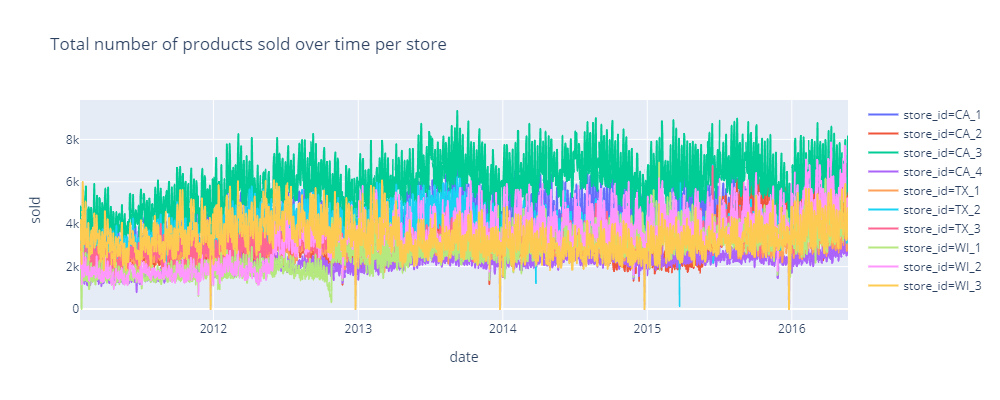

In [2]:
Image(filename='Plots/1.png') 

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=4,subplot_titles=('CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3','',
 'WI_1',
 'WI_2',
 'WI_3' ))

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_1']['sold'])), row = 1, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_2']['sold'])), row = 1, col=2 )


fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_3']['sold'])), row = 1, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_4']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_4']['sold'])), row = 1, col=4 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_1']['sold'])), row = 2, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_2']['sold'])), row = 2, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_3']['sold'])), row = 2, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_1']['sold'])), row = 3, col = 1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_2']['sold'])), row = 3, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_3']['sold'])), row = 3, col=3 )


fig.update_layout(height=800, width=2000, title_text="Total number of products sold over time per store")
fig.show()

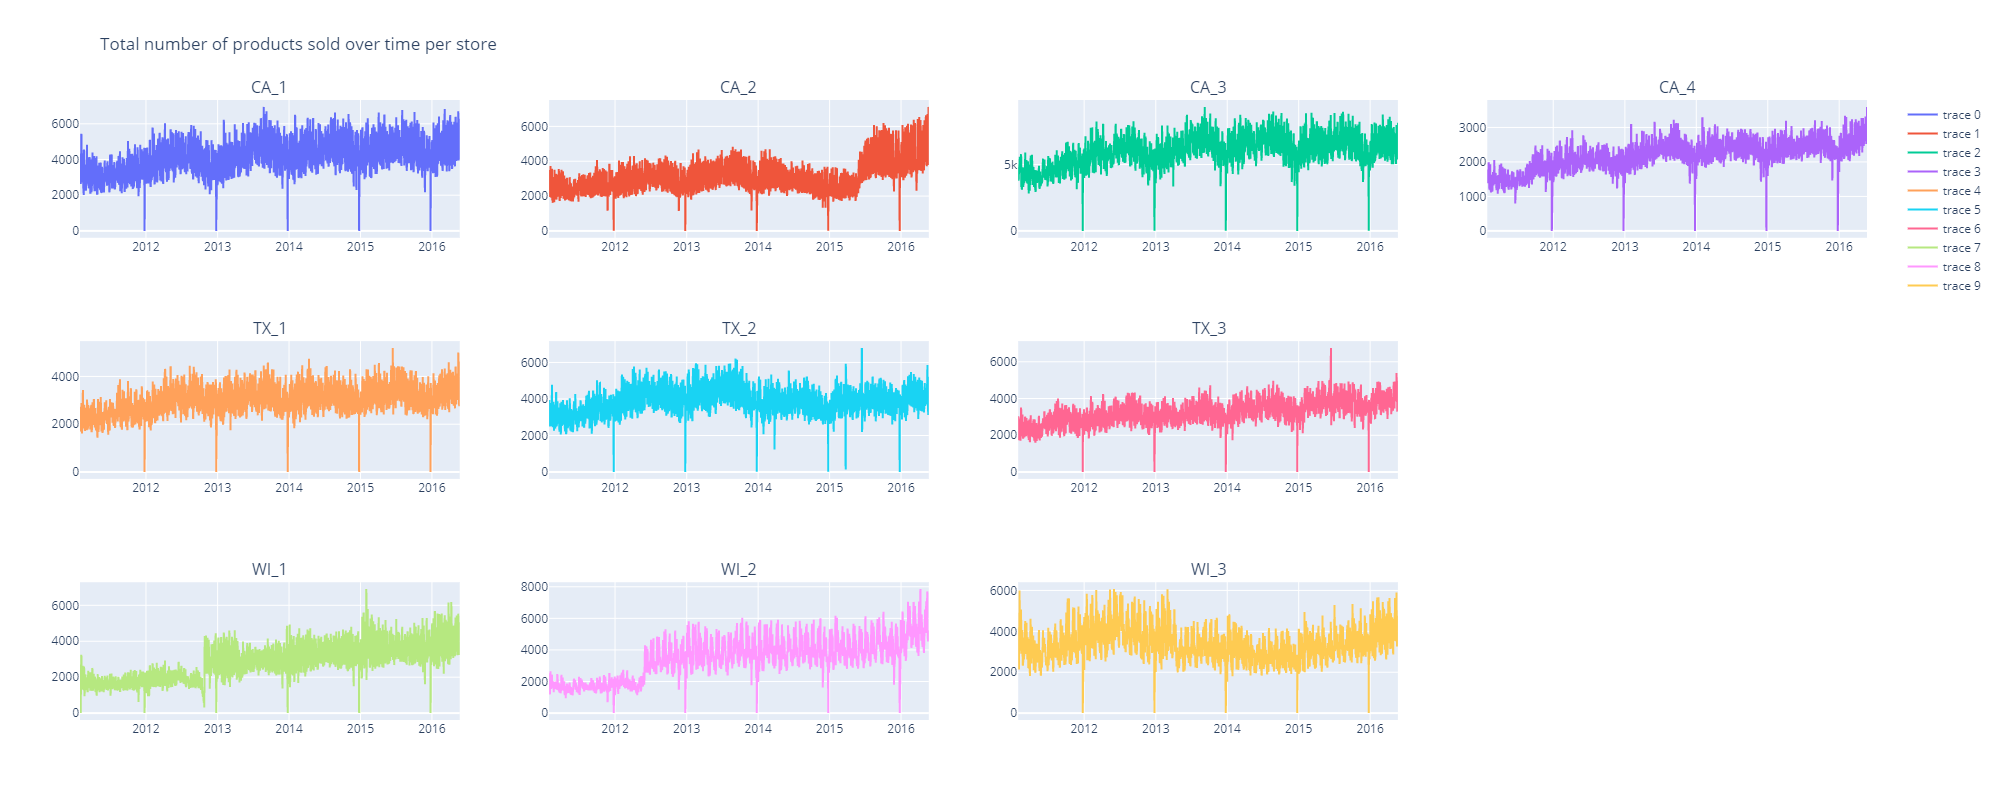

In [4]:
Image(filename='Plots/Plot 1.png') 

Observations :-

1. CA_3 store sells most number of products daily as compared to any other store.
2. The number of products sold daily increased for CA_2 just before the mid of 2015.
3. The number of products sold daily increased for WI_1 during the end months of 2012.
4. The number of products sold daily increased for WI_2 during the mid of 2012.

## Plot 2 :- Total number of products sold over time per state

In [ ]:

grouped = df.groupby(['state_id','date']).sum()
grouped.reset_index( inplace=True)

In [5]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'state_id' ,title='Total number of products sold over time per state')
fig.update_layout(width=1000, height=400)
fig.show()

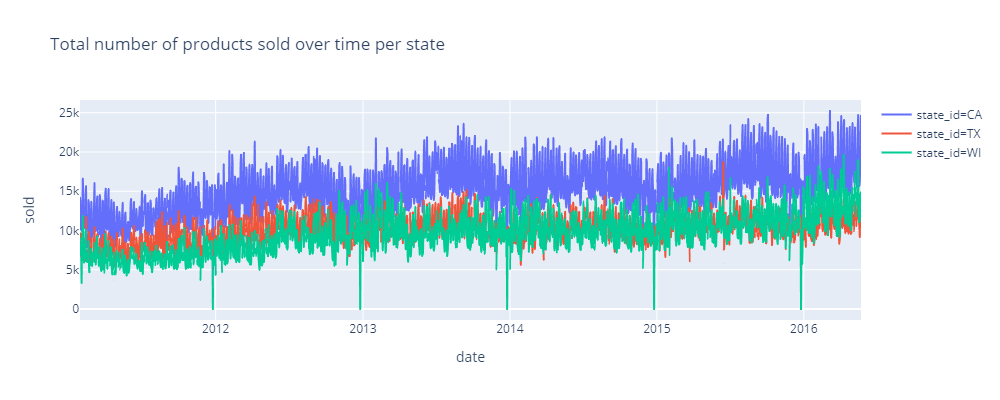

In [6]:
Image(filename='Plots/Plot 2.png') 

Observations :-
1. CA sells most number of products daily .
2. The number of products sold daily were more for TX as compared to WI before 2013 ,but after 2013 the sold value for both the states tends to fall in the same range as the plot for both the states seems to overlap for most of the time.

## Plot 3 :- Total number of products sold over time for all categories of items

In [ ]:

grouped = df.groupby(['cat_id','date']).sum()
grouped.reset_index( inplace=True)

In [7]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'cat_id' ,title='Total number of products sold over time for all categories of items')
fig.update_layout(width=1000, height=400)
fig.show()

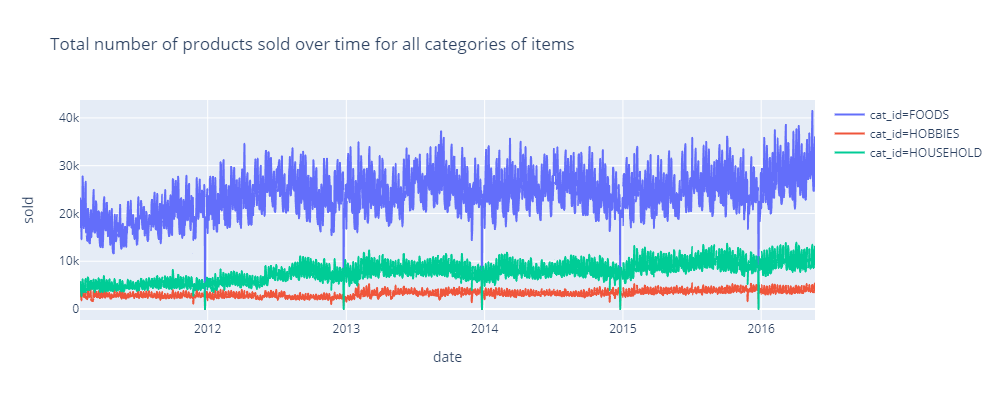

In [8]:
Image(filename='Plots/Plot 3.png') 

Observations :-
1. FOODS is the most sold item category.
2. HOOBIES is the least sold item category.
3. The plot for FOODS category seems to have a yearly trend .
4. The plot for HOBBIES category does not seem to have any trend.
5. The sold values for HOUSEHOLD category has noticabely increased during the mid of 2012. 

## Plot 4 :- Total revenue generated daily from all the items sold for all the stores.

In [ ]:
df['revenue'] = df['sold'] * df['sell_price']

In [ ]:
grouped = df.groupby(['store_id','date']).sum()
grouped.reset_index( inplace=True)

In [9]:
fig = px.line(grouped ,x = 'date', y = 'revenue',color = 'store_id' ,title='Total revenue generated daily from all the items sold for all the stores')
fig.update_layout(width=1000, height=400)
fig.show()

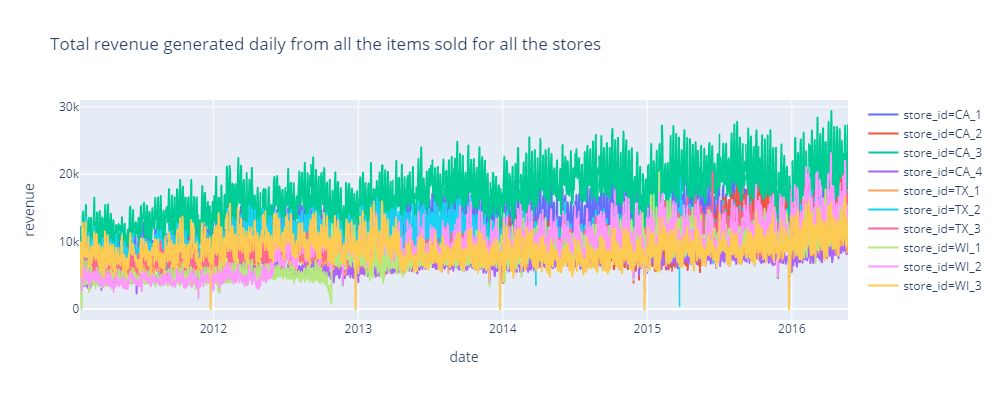

In [10]:
Image(filename='Plots/Plot 4.png') 

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=4,subplot_titles=('CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3','',
 'WI_1',
 'WI_2',
 'WI_3' ))

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_1']['revenue'])), row = 1, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_2']['revenue'])), row = 1, col=2 )


fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_3']['revenue'])), row = 1, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'CA_4']['date']), y=list(grouped.loc[grouped['store_id'] == 'CA_4']['revenue'])), row = 1, col=4 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_1']['revenue'])), row = 2, col=1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_2']['revenue'])), row = 2, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'TX_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'TX_3']['revenue'])), row = 2, col=3 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_1']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_1']['revenue'])), row = 3, col = 1 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_2']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_2']['revenue'])), row = 3, col=2 )

fig.add_trace(
    go.Scatter(x=list(grouped.loc[grouped['store_id'] == 'WI_3']['date']), y=list(grouped.loc[grouped['store_id'] == 'WI_3']['revenue'])), row = 3, col=3 )


fig.update_layout(height=800, width=2000, title_text="Total number of products sold over time per store")
fig.show()

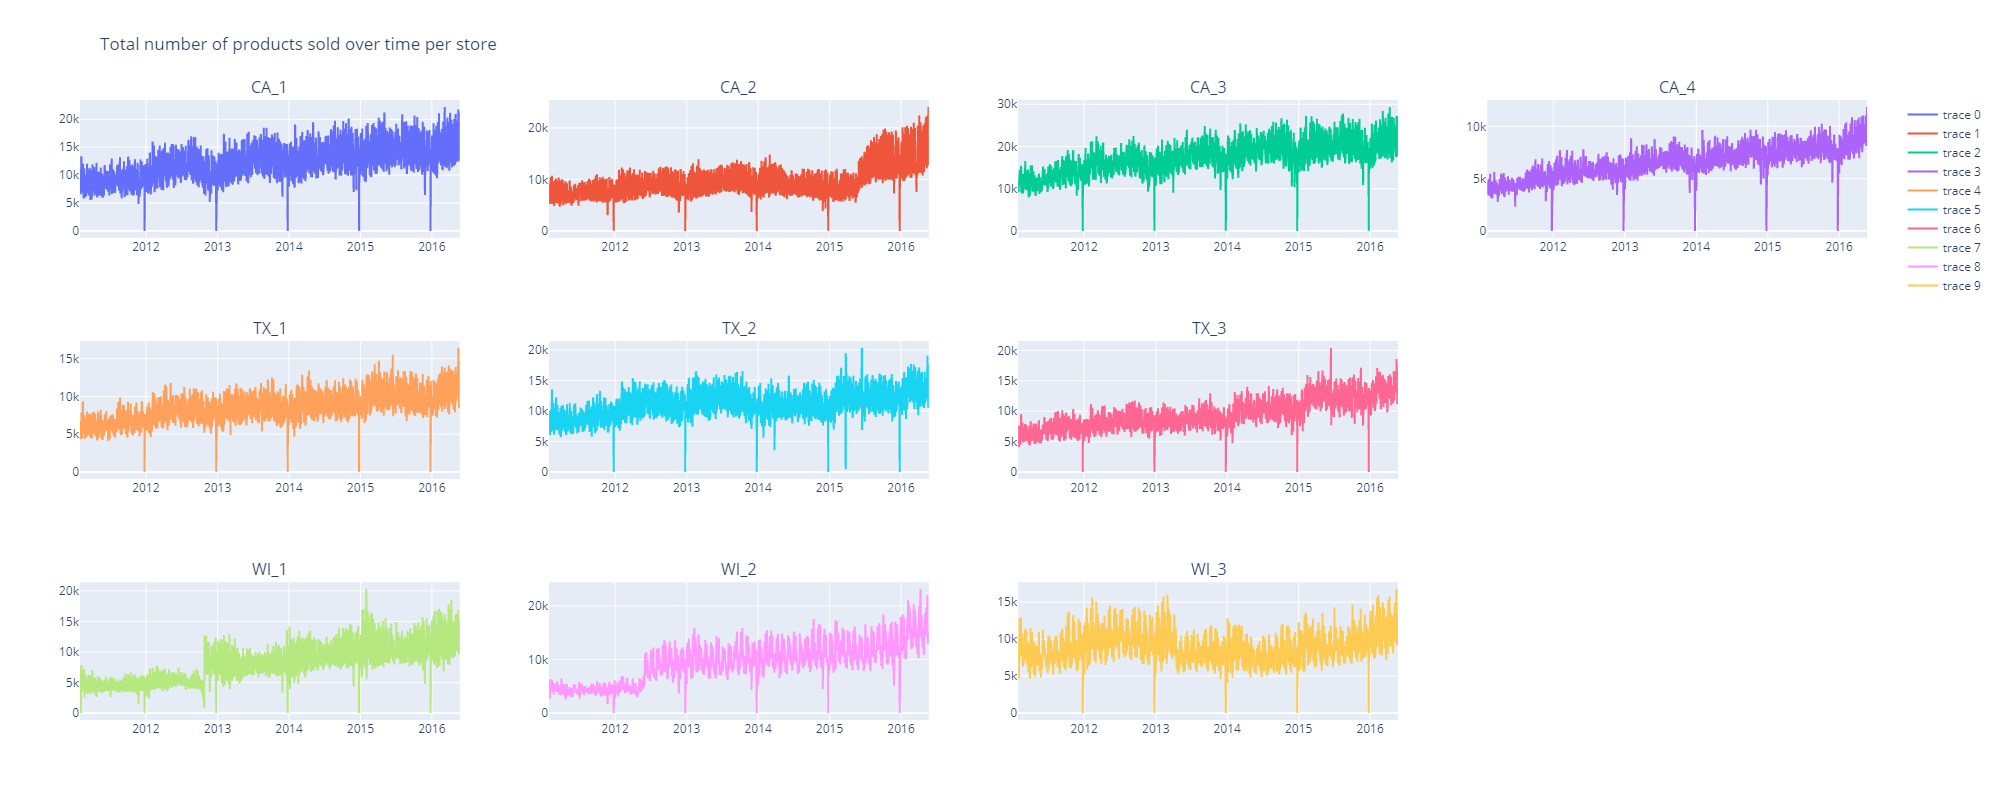

In [12]:
Image(filename='Plots/Plot 4_2.png') 

Observations :-
1. CA_3 generates most revenue as compared to the other stores.
2. All observations are similar to the observations in Plot 1 :- Total number of products sold over time per store.


## Plot 5  :- Total number of items sold in each store for each category

In [ ]:
# df

In [ ]:
grouped = df.groupby(['store_id','cat_id'], as_index=False).sum().dropna()
# grouped.reset_index( inplace=True)

In [ ]:
# grouped

In [ ]:
x_axis = grouped['store_id'].unique()
x_axis

['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
Categories (10, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4', ..., 'TX_3', 'WI_1', 'WI_2', 'WI_3']

In [13]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS',text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES',text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Total number of items sold in each store for each category')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(width=1000, height=400)
fig.show()

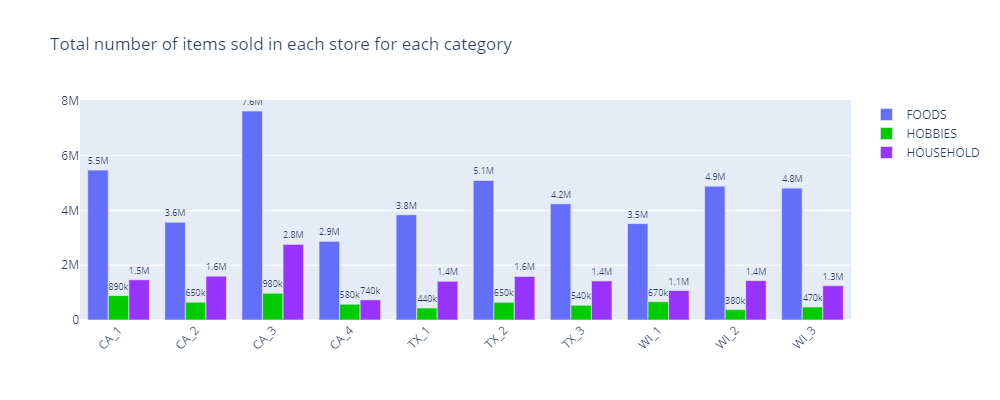

In [14]:
Image(filename='Plots/Plot 5.png') 

Observations :-
1. CA_3 sold the most FOODS and HOUSEHOLD category items.
2. CA_3 sold HOOBIES category items more than CA_1 but the difference is very less.
3. The difference in number of items sold in HOBBIES category accross all the stores is very less as compared to FOODS and HOUSEHOLD categories.

## Plot 6 :- Total number of items sold in each state for each category

In [ ]:
grouped = df.groupby(['state_id','cat_id'], as_index=False).sum().dropna()
x_axis = grouped['state_id'].unique()

In [ ]:
x_axis

['CA', 'TX', 'WI']
Categories (3, object): ['CA', 'TX', 'WI']

In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS',text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title_text='Total number of items sold in each state for each category')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(width=1000, height=500)
fig.show()

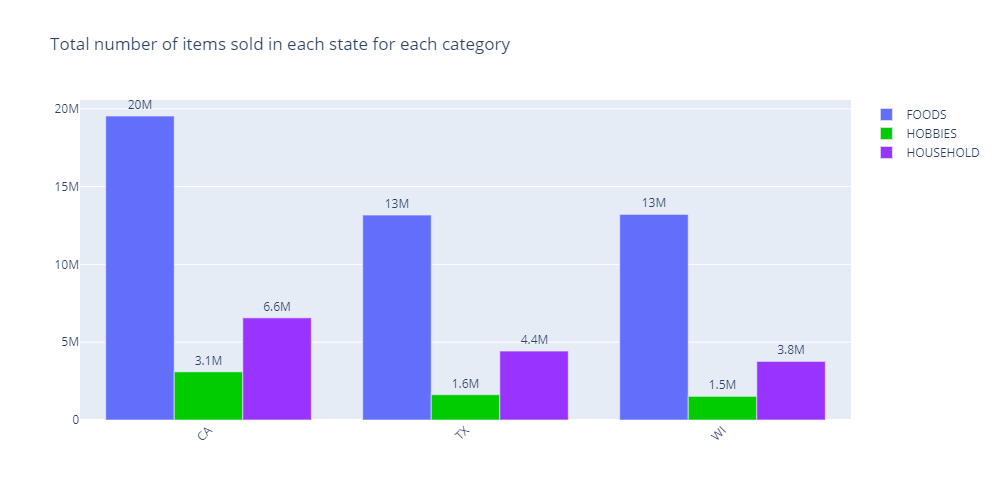

In [16]:
Image(filename='Plots/Plot 6.png') 

Observations :-
1. CA sold most items in all the categories.
2. CA sold almost double the items in HOBBIES category as compared to TX and WI.
3. TX and WI sold almost same number of items in FOODS category.
4. TX sold more items than WI in HOUSEHOLD category.


## Plot 7 :- Distribution of prices of different categories in different stores

In [ ]:
# df

In [ ]:
grouped = df.groupby(['store_id','cat_id','item_id'], as_index=False)['sell_price'].mean()
grouped.dropna()

,store_id,cat_id,item_id,sell_price
0,CA_1,FOODS,FOODS_1_001,2.167969
1,CA_1,FOODS,FOODS_1_002,8.929688
2,CA_1,FOODS,FOODS_1_003,2.972656
3,CA_1,FOODS,FOODS_1_004,1.849609
4,CA_1,FOODS,FOODS_1_005,3.330078
...,...,...,...,...
91465,WI_3,HOUSEHOLD,HOUSEHOLD_2_512,3.970703
91466,WI_3,HOUSEHOLD,HOUSEHOLD_2_513,2.779297
91467,WI_3,HOUSEHOLD,HOUSEHOLD_2_514,18.796875
91468,WI_3,HOUSEHOLD,HOUSEHOLD_2_515,1.969727


In [ ]:
# grouped.head()
# sell_prices

In [17]:
import plotly.express as px

fig = px.box(grouped, x="store_id", y="sell_price", color="cat_id")
fig.update_layout(title_text='Distribution of prices of different categories in different stores')
fig.show()

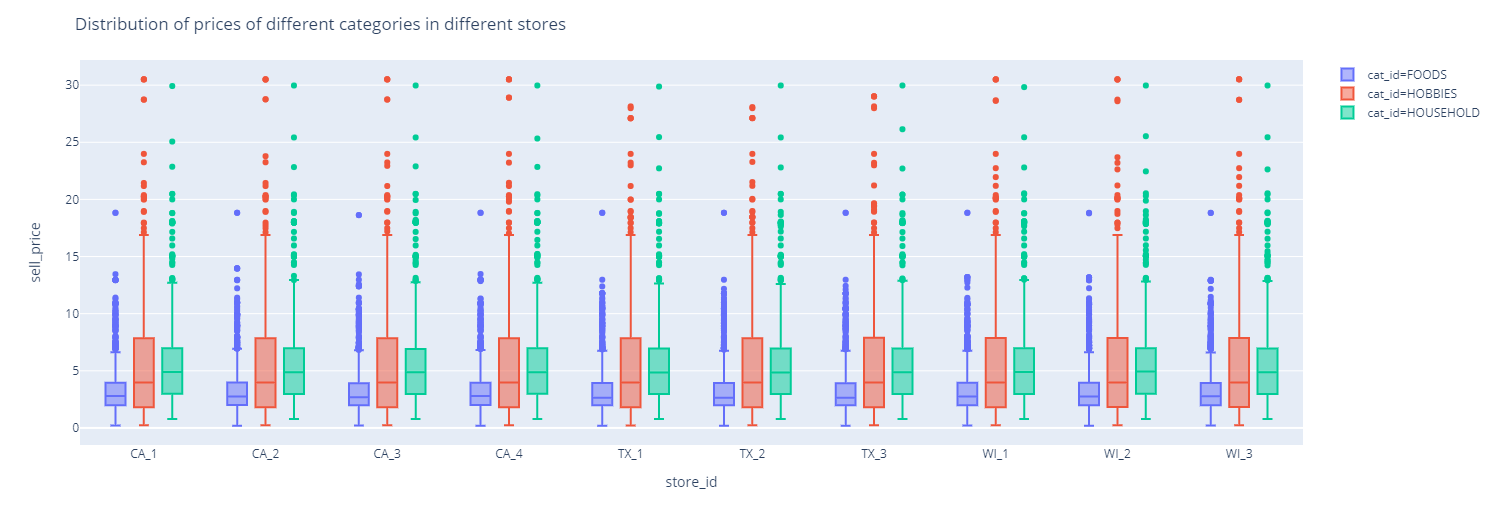

In [18]:
Image(filename='Plots/Plot 7.png') 

Observations :-
1. HOBBIES category items have the largest price range.
2. FOODS category items have the least price range.
3. The median price for HOUSEHOLD category is more as compared to FOODS and HOBBIES.
4. The distribution of price range for all items seems to be very similar for all the stores.


## Plot 8 :- Total number of products sold for all subcategories of items per store

In [ ]:
grouped = df.groupby(['store_id','dept_id'], as_index=False)['sold'].sum()
grouped.dropna()

,store_id,dept_id,sold
0,CA_1,FOODS_1,577436.0
1,CA_1,FOODS_2,900391.0
2,CA_1,FOODS_3,3993834.0
3,CA_1,HOBBIES_1,835578.0
4,CA_1,HOBBIES_2,56505.0
...,...,...,...
65,WI_3,FOODS_3,3578587.0
66,WI_3,HOBBIES_1,432938.0
67,WI_3,HOBBIES_2,41678.0
68,WI_3,HOUSEHOLD_1,1035759.0


In [19]:
fig = px.box(grouped, x="dept_id", y="sold")
fig.update_layout(title_text='Total number of products sold for all subcategories of items per store',width=800, height=400)
fig.show()

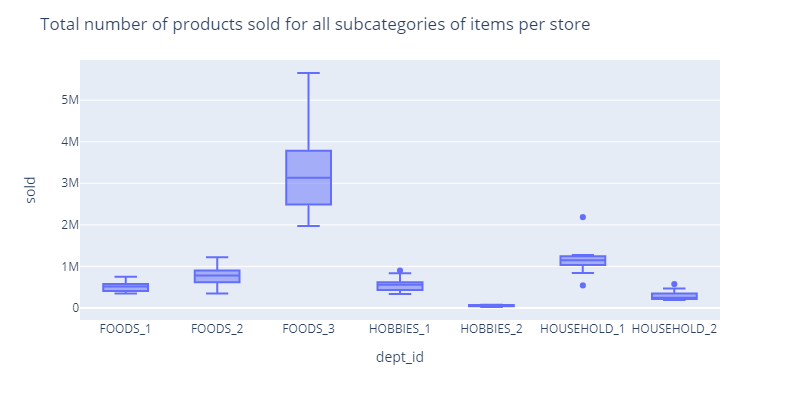

In [20]:
Image(filename='Plots/Plot 8.png') 

Observations :-
1. FOODS_3 category have the most sold items among all the stores.
2. FOODS_3 have the largest range for the number of items sold in different stores. It also has the highest variance in sales.

2. HOBBIES_2 category have the least sold items among all the stores. It also has the least variance in sales.

#### Highest sold item in FOODS_3 :-

In [ ]:
df_F_3 = df.loc[(df['dept_id'] == "FOODS_3")]

grouped = df_F_3.groupby(["dept_id",'item_id'],as_index=False)['sold'].sum()
grouped.dropna(inplace = True)


In [ ]:
grouped.sort_values('sold' ,inplace = True)
grouped

,dept_id,item_id,sold
6930,FOODS_3,FOODS_3_220,885.0
6881,FOODS_3,FOODS_3_171,1142.0
7182,FOODS_3,FOODS_3_472,1183.0
6965,FOODS_3,FOODS_3_255,1394.0
7311,FOODS_3,FOODS_3_601,1558.0
...,...,...,...
7297,FOODS_3,FOODS_3_587,402159.0
7265,FOODS_3,FOODS_3_555,497881.0
6962,FOODS_3,FOODS_3_252,573723.0
7296,FOODS_3,FOODS_3_586,932236.0


In [21]:
fig = px.bar(grouped, x='item_id', y='sold', text='sold') 
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(barmode='stack', xaxis_tickangle=-45 ,width=1500, height=600 )
fig.update_layout(title_text='Items sold in FOODS_3')
fig.show()


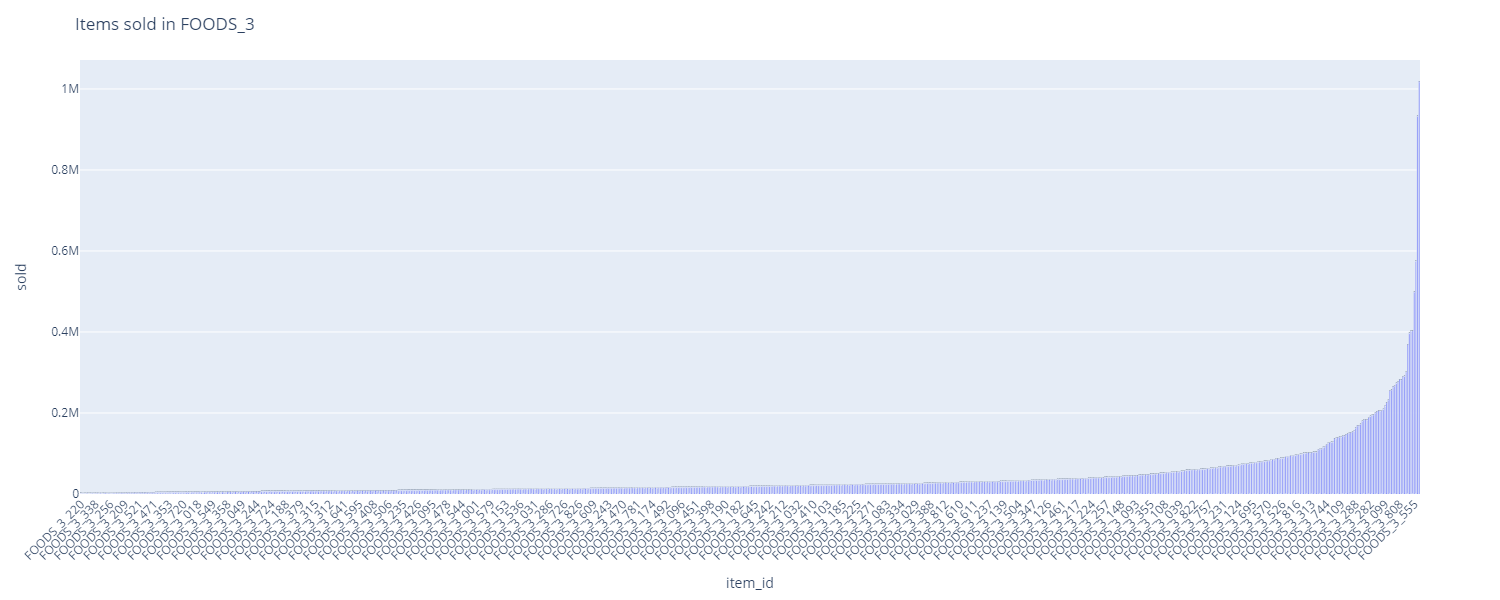

In [22]:
Image(filename='Plots/Plot 8_2.png') 

Observations :-
1. FOODS_3_090 (units sold = 1017916) is the most sold item in FOODS_3.


## Plot 9 :- Total number of products sold in events in 2016

In [ ]:
df.tail()
df_2016 = df.loc[df['year'] == 2016]

# df_2016

In [ ]:
grouped = df_2016.groupby(['date','event_type_1','event_name_1','cat_id'], as_index=False)['sold'].sum()
grouped.dropna(inplace=True)
grouped.head()

,date,event_type_1,event_name_1,cat_id,sold
144,2016-01-01,National,NewYear,FOODS,21078.0
145,2016-01-01,National,NewYear,HOBBIES,3182.0
146,2016-01-01,National,NewYear,HOUSEHOLD,8391.0
2397,2016-01-07,Religious,OrthodoxChristmas,FOODS,24445.0
2398,2016-01-07,Religious,OrthodoxChristmas,HOBBIES,3327.0


In [ ]:
x_axis = grouped['event_name_1'].unique()

In [23]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS',text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45 ,width=1500, height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text=' Total number of products sold in events in 2016')
fig.show()

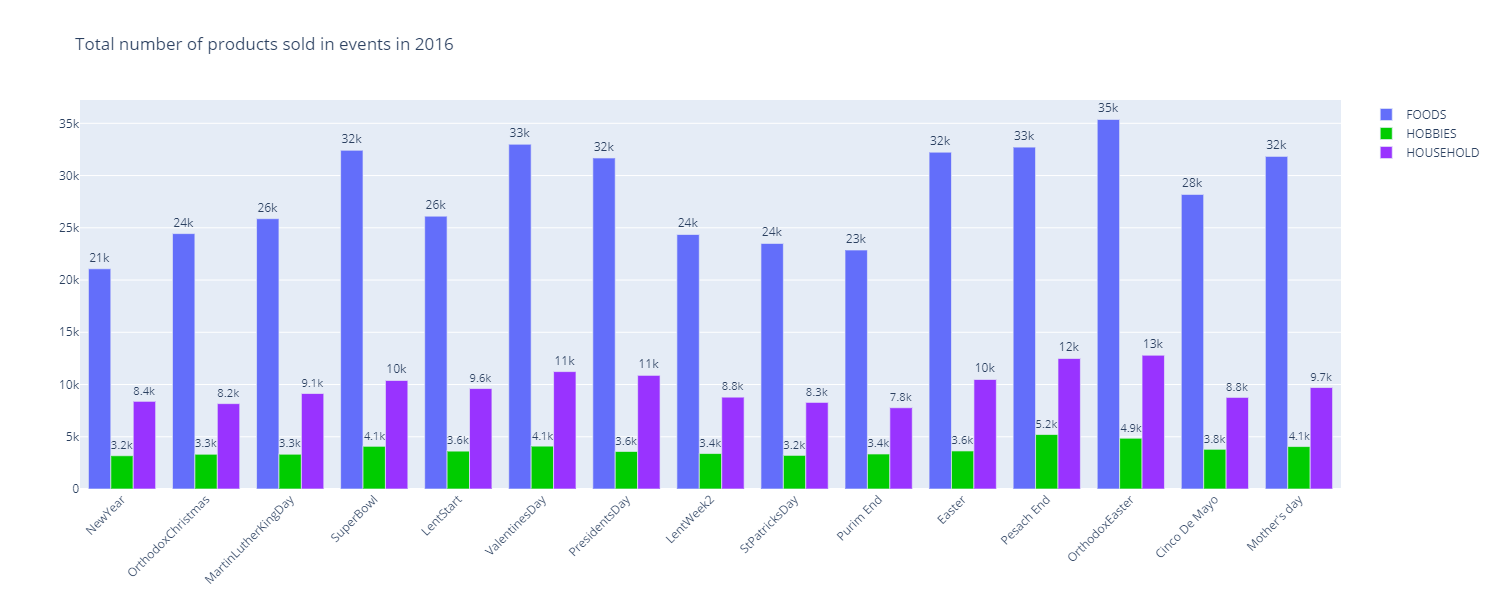

In [24]:
Image(filename='Plots/Plot 9.png') 

Observations :-
1. Most of the FOODS and HOUSEHOLD category items were sold on Orthodox Easter day in 2016.
2. On SuperBowl , Valentine's Day, President's Day, Easter ,Pesach End, Orthodox Easter and Mother's Day more than 30000 FOODS category items were sold in 2016.


## Plot 10 :- Products sold in SNAP


In [ ]:
df_snap = df.loc[(df['snap_CA'] == 1) | (df['snap_TX'] == 1) | (df['snap_WI'] == 1)]
grouped = df.groupby(['store_id','cat_id'], as_index=False)['sold'].sum()
grouped.dropna(inplace=True)
grouped

,store_id,cat_id,sold
0,CA_1,FOODS,5471661.0
1,CA_1,HOBBIES,892083.0
2,CA_1,HOUSEHOLD,1468504.0
3,CA_2,FOODS,3567477.0
4,CA_2,HOBBIES,650360.0
5,CA_2,HOUSEHOLD,1600558.0
6,CA_3,FOODS,7625660.0
7,CA_3,HOBBIES,977613.0
8,CA_3,HOUSEHOLD,2760267.0
9,CA_4,FOODS,2871065.0


In [ ]:
x_axis = grouped['store_id'].unique()
x_axis


['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
Categories (10, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4', ..., 'TX_3', 'WI_1', 'WI_2', 'WI_3']

In [25]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS', text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold']
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45,width=1000, height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text=' Total number of products sold during SNAP in stores')
fig.show()

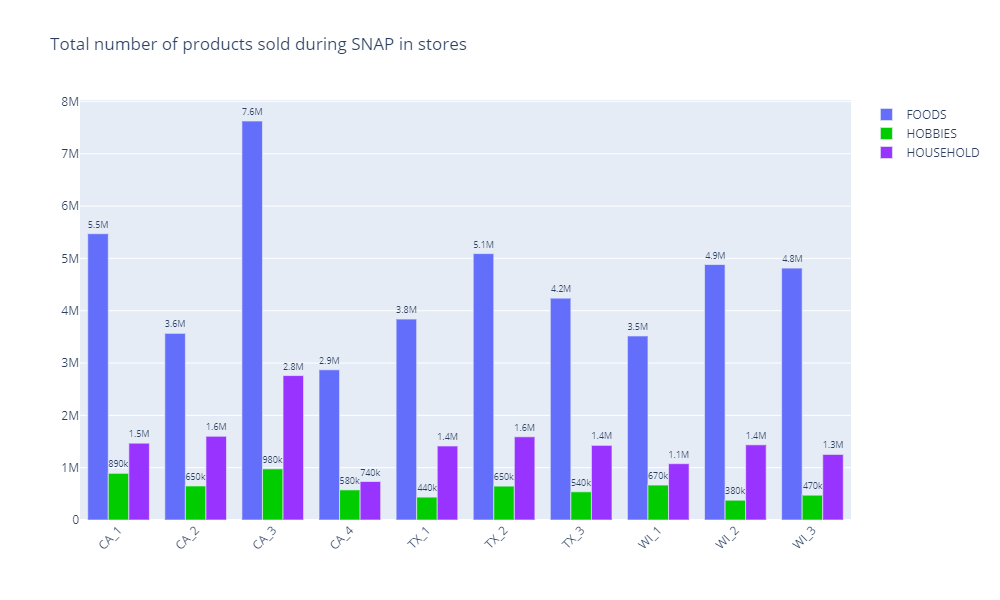

In [26]:
Image(filename='Plots/Plot 10.png') 

Observations :-

1. CA_3 sold most number of items in every category among all the stores during SNAP.
2. CA_4 sold least number of FOODS category items during SNAP.
3. WI_2 and WI_3 sold almost same number of FOODS category items during SNAP.


## Plot 11 :- Products sold on weekdays and weekends

In [ ]:
# df

In [ ]:
grouped = df.groupby(['wday','cat_id'], as_index=False)['sold'].sum()
grouped.dropna(inplace=True)
grouped.head()

,wday,cat_id,sold
0,1,FOODS,7832803.0
1,1,HOBBIES,1097354.0
2,1,HOUSEHOLD,2664186.0
3,2,FOODS,7911666.0
4,2,HOBBIES,995802.0


In [ ]:
x_axis = [ 'Saturday', 'Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

list

In [27]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
    name='FOODS', text = grouped.loc[(grouped['cat_id'] == 'FOODS')]['sold'],
   
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    name='HOBBIES', text = grouped.loc[(grouped['cat_id'] == 'HOBBIES')]['sold'],
    marker_color='rgb(0, 204, 0)'
))
fig.add_trace(go.Bar(
    x=x_axis,
    y=grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    name='HOUSEHOLD	', text = grouped.loc[(grouped['cat_id'] == 'HOUSEHOLD')]['sold'],
    marker_color='rgb(153, 51, 255)'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45,width=1000, height=600)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Products sold on weekdays and weeknds ')
fig.show()

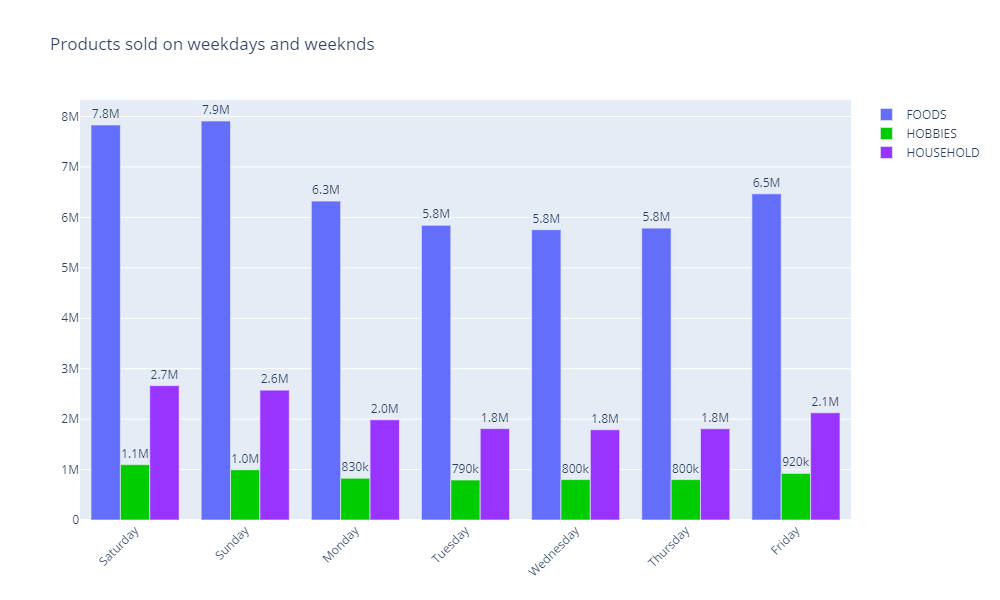

In [28]:
Image(filename='Plots/Plot 11.png') 

Observations :-

1. People buy more products on weeknds than on weekdays for all item categories.
2. The FOODS category items are sold most on Sunday.
3. The HOBBIES and HOUSEHOLD category items are sold most on Saturday.


## State Wise monthly analysis of 2016

For 2016 we have data until 22nd of May , so all the analysis done will be upto this day.


## Plot 12 :- California

Monthly analysis

In [ ]:
# df

In [ ]:
df_CA = df.loc[(df['state_id'] == "CA") & (df['year'] == 2016) ]


In [ ]:
# df_CA

In [ ]:
# Monthly Analysis
df_CA= df.loc[(df['state_id'] == "CA") & (df['year'] == 2016)  ]

grouped = df_CA.groupby(['store_id','date']).sum()
grouped.dropna(inplace = True)
grouped.reset_index( inplace=True)


In [29]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'store_id' ,title='Total number of products sold in each store in California during 2016')
fig.update_layout(width=1000, height=400)
fig.show()

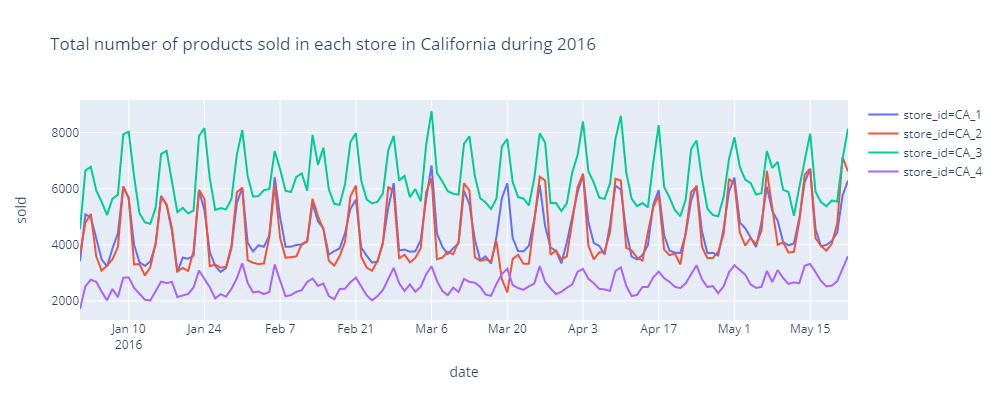

In [30]:
Image(filename='Plots/Plot 12.png') 

Observations :-
1. There is a sudden derease in sales for store CA_2 on March 20 2016 (products sold = 2300). We will look further into this.

Daily analysis

In [ ]:
df_CA= df.loc[(df['state_id'] == "CA") & (df['year'] == 2016) & (df['month'] == 3) & (df['store_id'] == "CA_2" )]

grouped = df_CA.groupby(['cat_id','date']).sum()
grouped.dropna(inplace = True)
grouped.reset_index( inplace=True)

In [31]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'cat_id' ,title='Total number of products sold in CA_2 during March 2016')
fig.update_layout(width=1000, height=400)
fig.show()

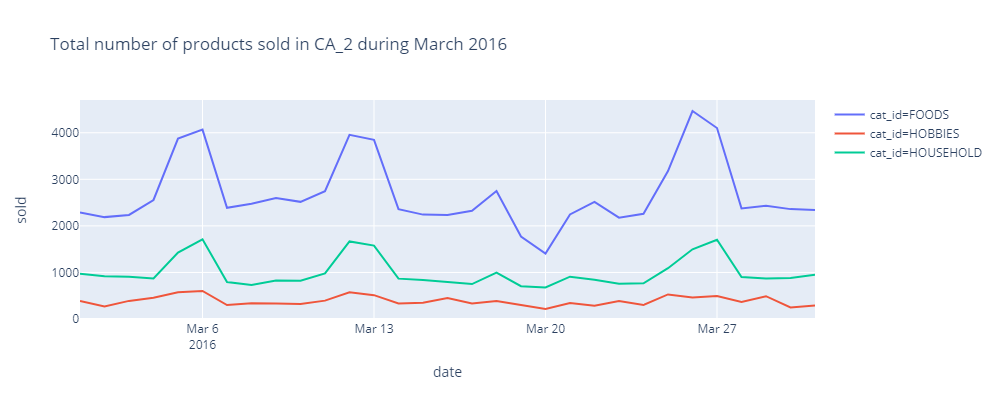

In [32]:
Image(filename='Plots/Plot 12_2.png') 

Observations :-
1. All item categories were sold least on March 20 2016 for store CA_2 ( FOODS = 1406 , HOBBIES = 215  , HOUSEHOLD = 679).

## Plot 13 :- Texas

Monthly Analysis

In [ ]:
# Monthly Analysis
df_TX= df.loc[(df['state_id'] == "TX") & (df['year'] == 2016) ]

grouped = df_TX.groupby(['store_id','date']).sum()
grouped.dropna(inplace = True)
grouped.reset_index( inplace=True)


In [33]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'store_id' ,title='Total number of products sold in each store in Texas during 2016')
fig.update_layout(width=1000, height=400)
fig.show()

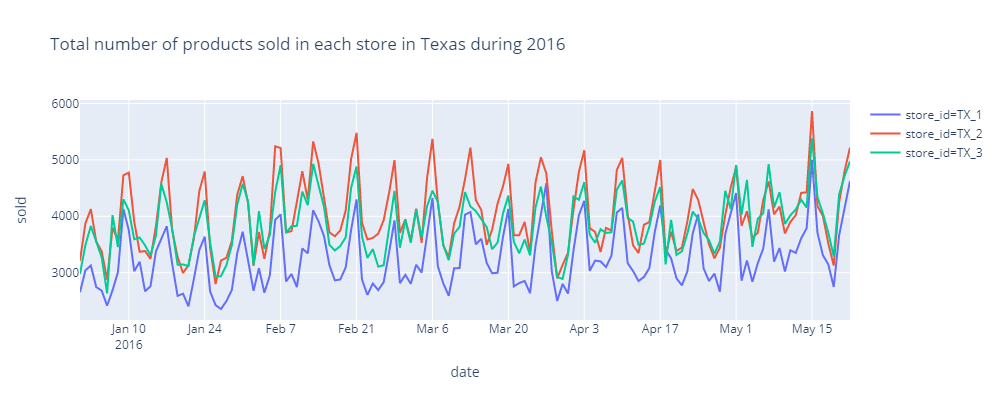

In [34]:
Image(filename='Plots/Plot 13.png') 

Observations :-
1. Most items were sold in Texas on May 15 2016 by the store TX_2 (proudcts sold = 5866). We will look deeper into this. 

Daily Analysis

In [ ]:

df_TX= df.loc[(df['store_id'] == "TX_2") & (df['year'] == 2016) &(df['month'] == 5 ) ]

grouped = df_TX.groupby(['cat_id','date']).sum()
grouped.dropna(inplace = True)
grouped.reset_index( inplace=True)


In [35]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'cat_id' ,title='Total number of products sold in TX_2 during May 2016')
fig.update_layout(width=1000, height=400)
fig.show()

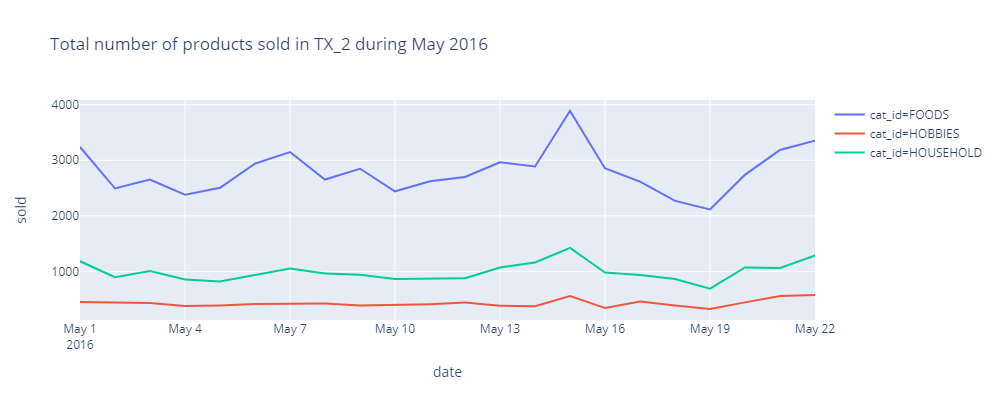

In [36]:
Image(filename='Plots/Plot 13_2.png') 

Observations :-
1. FOODS and HOUDEHOLD (FOODS = 3887, HOUSEHOLD = 1423)  items had the highest sale on May 15 2016.

## Plot 14 :- Wisconsin

Monthly Analysis

In [ ]:
# Monthly Analysis
df_WI= df.loc[(df['state_id'] == "WI") & (df['year'] == 2016) ]

grouped = df_WI.groupby(['store_id','date']).sum()
grouped.dropna(inplace = True)
grouped.reset_index( inplace=True)


In [37]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'store_id' ,title='Total number of products sold in each store in Wisconsin during 2016')
fig.update_layout(width=1000, height=400)
fig.show()

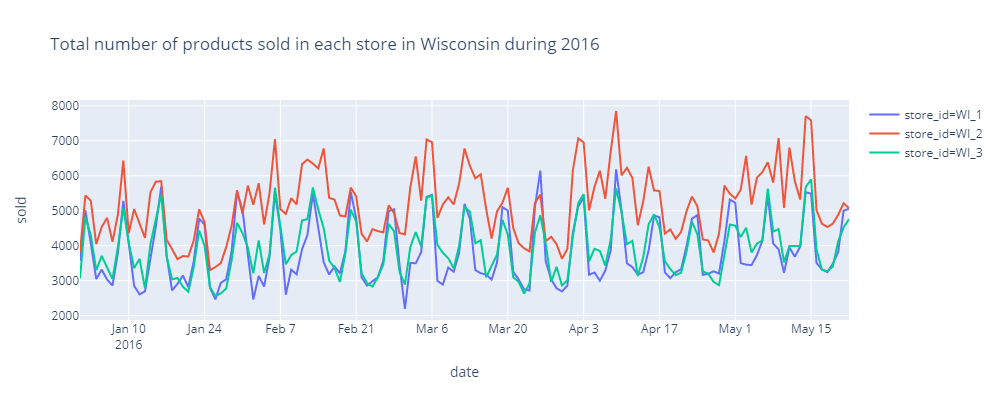

In [38]:
Image(filename='Plots/Plot 14.png') 

Observations :-

1. Highest number of products were sold in Wisconsin by WI_2 store on April 9 2016 (products sold = 7852).

Daily Analysis

In [ ]:
df_WI= df.loc[(df['year'] == 2016) & (df['store_id'] == "WI_2")&(df['month'] == 4 ) ]

grouped = df_WI.groupby(['cat_id','date']).sum()
grouped.dropna(inplace = True)
grouped.reset_index( inplace=True)

In [39]:
fig = px.line(grouped ,x = 'date', y = 'sold',color = 'cat_id' ,title='Total number of products sold in WI_2 during April 2016')
fig.update_layout(width=1000, height=400)
fig.show()

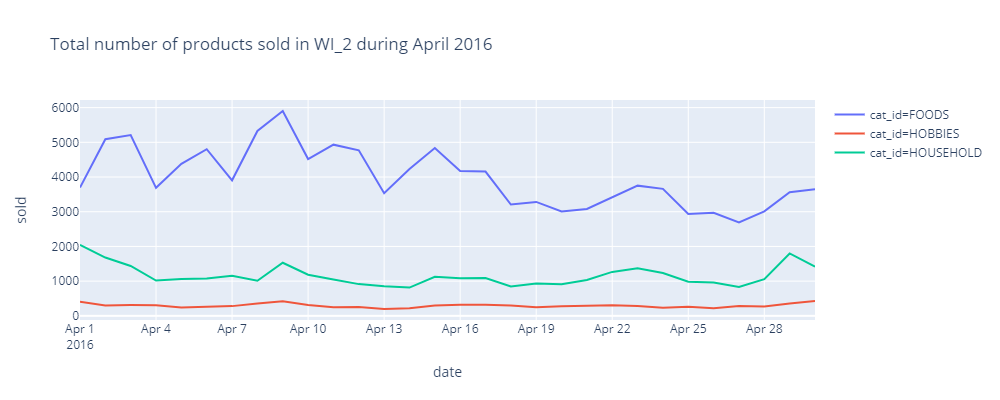

In [40]:
Image(filename='Plots/Plot 14_2.png') 

Observations :-
1. FOODS (FOODS = 5902) item category had the highest sale on April 9 2016.